# Lesson 1 - recreation of dog/cat classifier

The goal of this is to retype the commands in the original notebook so that I more fully understand them.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/dogscats/"
image_size = 224

## Analyzing data a bit

In [4]:
os.listdir(f'{PATH}valid/cats')[:5]

['cat.11341.jpg',
 'cat.3869.jpg',
 'cat.5089.jpg',
 'cat.7380.jpg',
 'cat.11409.jpg']

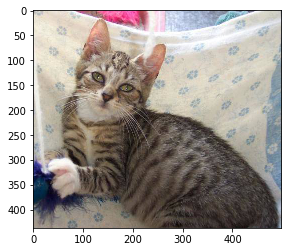

In [5]:
img = plt.imread(f'{PATH}valid/cats/cat.11341.jpg')
plt.imshow(img)

In [6]:
img.shape

(437, 499, 3)

## Actually training a model

In [7]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, image_size))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.050292   0.026495   0.9905    
    1      0.044753   0.024706   0.9895                       



[array([0.02471]), 0.9895]

## Analysis of the results

In [8]:
data.classes

['cats', 'dogs']

In [9]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [10]:
log_preds[:10]

array([[ -0.00004, -10.16641],
       [ -0.00265,  -5.93589],
       [ -0.00101,  -6.89599],
       [ -0.00088,  -7.03238],
       [ -0.00032,  -8.04529],
       [ -0.00109,  -6.81837],
       [ -0.00024,  -8.31924],
       [ -0.00004, -10.22268],
       [ -0.00701,  -4.96341],
       [ -0.00036,  -7.91743]], dtype=float32)

In [11]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

In [12]:
def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct):
    return rand_by_mask((preds == data.val_y) == is_correct)

In [13]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [14]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [15]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


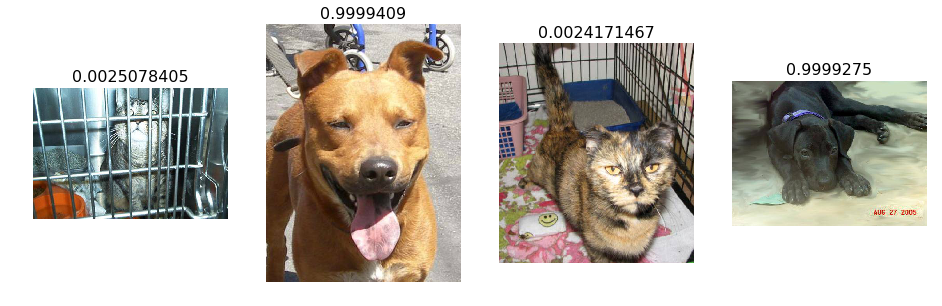

In [16]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


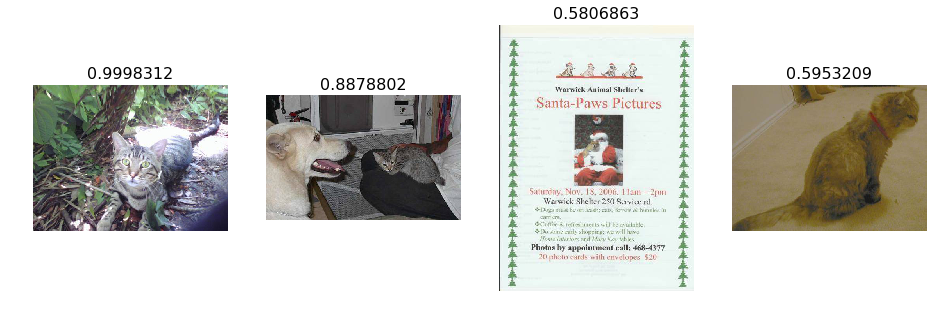

In [17]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [18]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


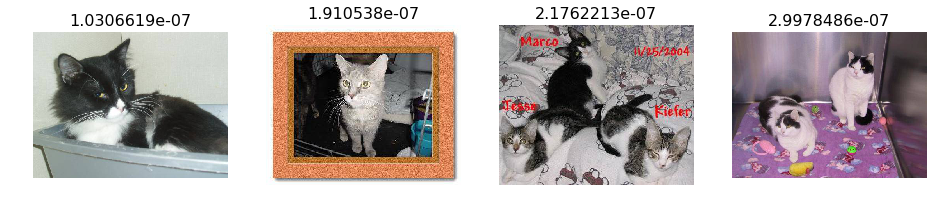

In [19]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


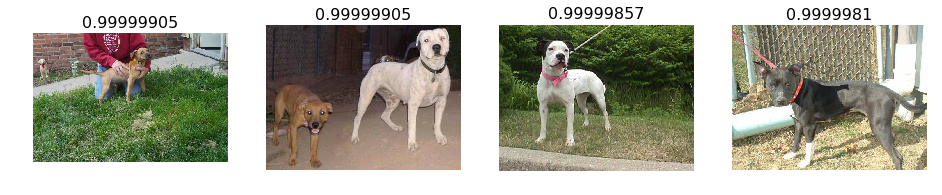

In [20]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


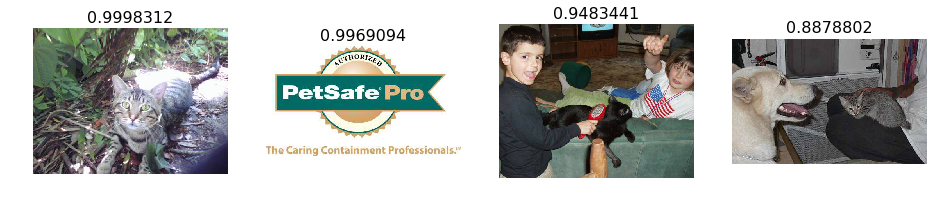

In [21]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


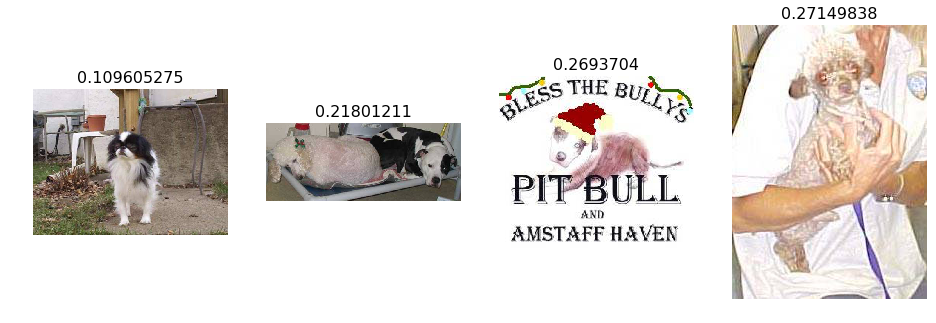

In [22]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


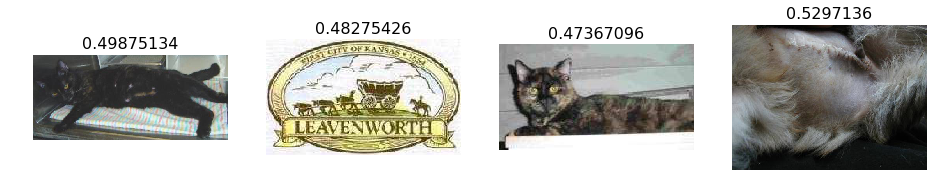

In [23]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing a learning rate

In [24]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [25]:
lrf=learn.lr_find()

 79%|███████▉  | 284/360 [00:04<00:01, 70.75it/s, loss=0.461]


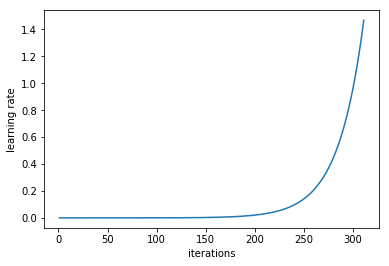

In [26]:
learn.sched.plot_lr()

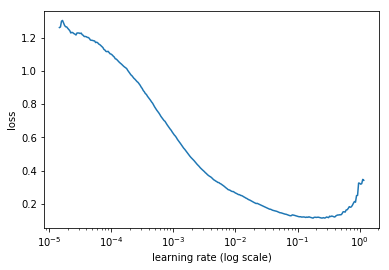

In [27]:
learn.sched.plot()

## Improving things

In [28]:
tfms = tfms_from_model(resnet34, image_size, aug_tfms=transforms_side_on, max_zoom=1.1)

In [30]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [31]:
ims = np.stack([get_augs() for i in range(6)])

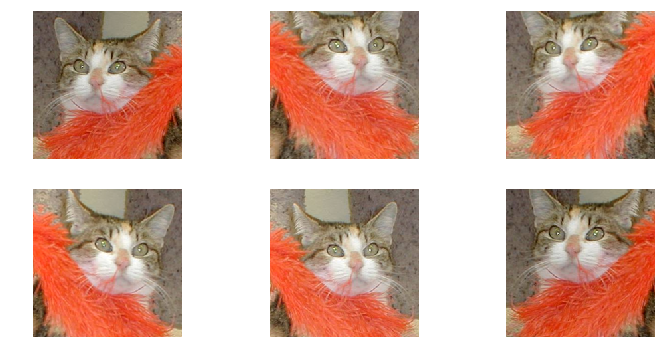

In [32]:
plots(ims, rows=2)

In [33]:
data_with_tfms = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data_with_tfms, precompute=True)

In [34]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.054152   0.028193   0.99      



[array([0.02819]), 0.99]

In [35]:
learn.precompute=False

In [36]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.037103   0.026695   0.991     
    1      0.044903   0.027276   0.991                        
    2      0.047521   0.027089   0.9905                       



[array([0.02709]), 0.9905]

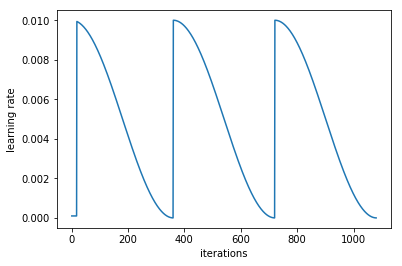

In [37]:
learn.sched.plot_lr()

In [38]:
learn.save('224_lastlayer')

In [39]:
learn.load('224_lastlayer')

## Fine-tuning

In [40]:
learn.unfreeze()

In [41]:
learning_rates = np.array([1e-4, 1e-3, 1e-2])

In [42]:
learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.051948   0.029039   0.9885    
    1      0.04444    0.021769   0.99                         
    2      0.029591   0.021498   0.991                        
    3      0.027053   0.019637   0.99                         
    4      0.027412   0.018969   0.9915                       
    5      0.020332   0.019206   0.9925                       
    6      0.020081   0.018848   0.9925                       



[array([0.01885]), 0.9925]

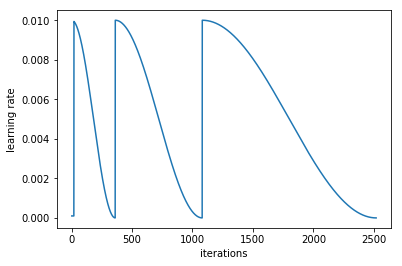

In [43]:
learn.sched.plot_lr()

In [44]:
learn.save('224_all')

In [45]:
learn.load('224_all')

## TTA

In [47]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)

In [48]:
accuracy_np(probs, y)

0.9935

## More analysis

In [50]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[994   6]
 [  7 993]]


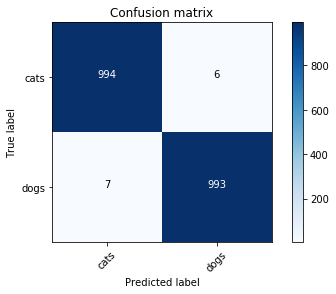

In [52]:
plot_confusion_matrix(cm, data.classes)